# 1. Includes



In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

# Eigene Module
import util.visual as vis
import util.utils as util
import util.model as md
import util.dataset as ds

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle
#sys.path.insert(1, os.path.join(sys.path[0], '../thirdparty'))
#sys.path.append('../thirdparty/review_object_detection_metrics')
import src.evaluators.coco_evaluator as coco
from src.bounding_box import BoundingBox

2.4.1
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# 2. Definitions
Hier werden die Dateipfade und Namen definiert

In [2]:
# Definitionen für selbst generierte Daten (Modelle, Graphen, ...)
models_path = '../data/models/'
model_name = 'experi_model'
logs_path = '../data/logs/'
chkpts_path = '../data/checkpoints/'
graphs_path = '../data/graphs/'
tables_path = '../data/tables/'

# Namen der Unterordner des Simulator Datasets ('1_1/', '1_2/', ..., '2_5/')
subfolders = []
for i in range(1, 3):
    for j in range(1, 6):
        subfolders.append(str(i) + '_' + str(j) + '/')

img_path = 'D:/workspace/datasets/simulator/1_1/images/'
csv_path = 'D:/workspace/datasets/simulator/1_1/labels.csv'
neg_csv_path = '../data/datasets/simulator/labels_with_negatives.csv'
params = util.get_params('../params.yaml')

# 3. Playground

In [3]:
model = tf.keras.models.load_model('../data/models/experimodel/experimodel.hdf5', custom_objects={'loss': md.multi_nao_loss})
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 160, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 160, 24)      240       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 120, 160, 24)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 160, 24)      96        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 80, 24)        5208      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 80, 24)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 80, 24)        96    

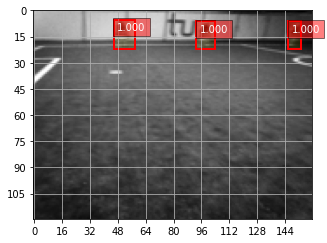

In [4]:
testset = ds.load_tfrecord_dataset('../data/datasets/ImageTagger/records/test/test_0.record').map(lambda x,y: (x, util.preprocess_true_boxes(y, params.model.grid.shape))).batch(1).skip(10).take(1)

for img, lbl in testset:
    vis.visualize_output_tensor(lbl, lbl, tf.squeeze(img), params.dataset.image.size, params.model.grid.shape, conf_threshold=0.3)

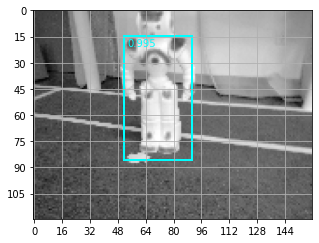

In [5]:
image = tf.keras.preprocessing.image.load_img('/home/maker/workspace/hskl-robocupgermanopen-2021/ObjectDetection/IMG_20210312_152911 2.jpg', color_mode="grayscale", target_size=(params.dataset.image.size[1], params.dataset.image.size[0]))

input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
pred = model.predict(input_arr)
#print(pred)
bbox_list_corners = util.postprocess_model_output(pred, params.dataset.image.size, conf_threshold=0.3)
#print(bbox_list_corners)
ax = vis.plot_image_with_grid(image, params.dataset.image.size, params.model.grid.shape)
vis.plot_bbox_list(ax, pred_bbox_list=bbox_list_corners)

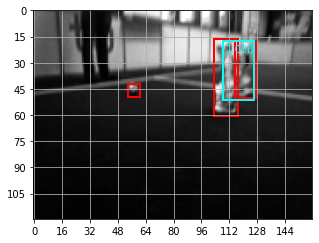

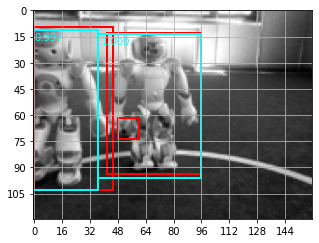

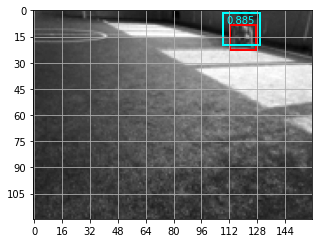

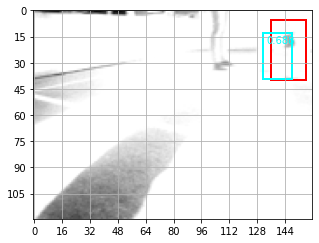

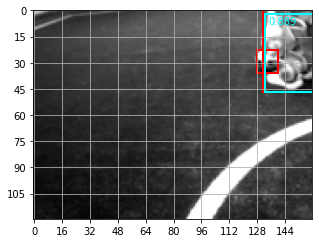

In [9]:
testset = ds.load_tfrecord_dataset('../data/datasets/ImageTagger/records/test/test_1.record').map(lambda x,y: (x, util.preprocess_true_boxes(y, params.model.grid.shape))).batch(1).skip(15).take(5)

true_bboxes_list = []
pred_bboxes_list = []
for id, (img, lbl) in enumerate(testset):
    pred = model.predict([img])

    true_bboxes = util.postprocess_dataset_labels(lbl, params.dataset.image.size)
    #print(true_bboxes)
    pred_bboxes = util.postprocess_model_output(pred, params.dataset.image.size, 0.6)
    ax = vis.plot_image_with_grid(tf.squeeze(img), params.dataset.image.size, params.model.grid.shape)
    vis.plot_bbox_list(ax, true_bbox_list=true_bboxes, pred_bbox_list=pred_bboxes)
    #vis.plot_bbox_list(ax, true_bbox_list=true_bboxes)
